In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

In [2]:
CHIME = pd.read_csv("./data/chimefrb.csv") #catalog from 07/14
CHIME

,tns_name,previous_name,repeater_name,snr_fitb,dm_fitb,dm_fitb_err,flux,flux_err,flux_notes,fluence,fluence_err,fluence_notes
0,FRB20180725A,180725.J0613+67,-9999,33.2,715.8090,0.0040,2.0,1.0,-9999,4.0,2.0,-9999
1,FRB20180727A,180727.J1311+26,-9999,12.2,642.1300,0.0200,0.6,0.3,-9999,2.3,0.8,-9999
2,FRB20180729A,180729.J1316+55,-9999,206.6,109.5942,0.0003,12.0,7.0,-9999,20.0,10.0,-9999
3,FRB20180729B,180729.J0558+56,-9999,22.0,317.2240,0.0040,0.9,0.6,-9999,1.2,0.7,-9999
4,FRB20180730A,180730.J0353+87,-9999,89.8,848.9040,0.0020,5.0,3.0,-9999,30.0,10.0,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...
594,FRB20190701A,-9999,-9999,14.6,637.0930,0.0040,1.3,0.2,-9999,1.7,0.3,-9999
595,FRB20190701B,-9999,-9999,17.5,749.1100,0.0100,1.1,0.5,-9999,1.9,0.7,-9999
596,FRB20190701C,-9999,-9999,16.8,974.1900,0.0300,0.9,0.5,-9999,2.0,2.0,-9999
597,FRB20190701D,-9999,-9999,44.8,933.3600,0.0100,1.3,0.7,-9999,9.0,4.0,-9999


In [41]:
#### unpack FRB-cat1 data published by CHIME ####

snr, dm, low_ft_95, up_ft_95, flux, flux_err, fluence, fluence_err, = np.loadtxt(
    './data/chimefrbcat1.csv', skiprows=1, usecols=(17, 18, 21, 22, 31, 32, 34, 35), delimiter=',', unpack=True)

tns = np.loadtxt('./data/chimefrbcat1.csv', dtype='str', skiprows=1, usecols=(0), delimiter=',')
fluence_notes = np.loadtxt('./data/chimefrbcat1.csv', dtype='str', skiprows=1, usecols=36, delimiter=',')

## note: low_ft_95, up_ft_95, flux, flux_err, fluence_err never used
##       tns, fluence_notes are never used
## only snr, dm, fluence are relevant

#### define minimmum fluence for each event #####

MIN_SNR = 12 # approx. threshold, according to CHIME's cat1 paper
min_fluence = fluence * (MIN_SNR / snr) # scale reported fluence 'snr' by SNR ratio

In [42]:
dm_new = np.array(CHIME['dm_fitb'])
snr_new = np.array(CHIME['snr_fitb'])
fluence_new = np.array(CHIME['fluence'])
MIN_SNR = 12
min_fluence_new = fluence_new * MIN_SNR/snr_new

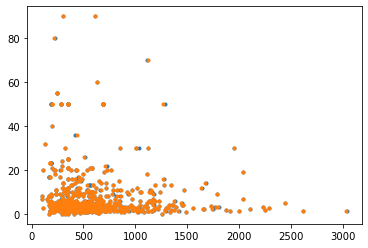

In [51]:
plt.scatter(dm_new, fluence_new, marker='.')
plt.scatter(dm, fluence, marker='.')

In [63]:
sum(abs(fluence-fluence_new))

0.0

In [43]:
import sys
import os
sys.path.append(os.path.abspath("../petrosianfuncs/"))
import cosmology as c
# rs = c.z_DM(DM)

K_MACQUART = 700/0.7 # approx. value of the proportionality constant linking redshift and dispersion
ISM = 30 # ansatz of interstellar medium's contribution to disperson, in pc cm-3
HALO = 50 # ansatz of MW's halo contribution to disperson, in pc cm-3

'''
function 'dm_ex' returns the extragalactic contribution to an FRB's total dispersion measure (dm_tot)
provided approx. values of the dispersion due to the interstellar medium (ISM) and the MW's halo (HALO)
'''
def dm_ex(dm_tot, dm_ism=ISM, dm_halo=HALO):
    return dm_tot - (dm_ism + dm_halo)

'''
function 'get_z' takes a dispersion measure and ansatz of the Macquart relation 
and returns corresponding redshift
'''
def get_z(dm, k=K_MACQUART):
    y = dm_ex(dm)
    arr = np.roots([1, (1 - y/k), ((1/k)*(50 - y))]) # apply Macquart relation
    zeroes = np.argwhere(arr > 0).flatten()
    if len(zeroes) > 0:
        return arr[zeroes].item()
    else:
        return 0

rs = []
rs_new = []

for i, dm_i in enumerate(dm):
    rs.append(get_z(dm_i))

for i, dm_i in enumerate(dm_new):
    rs_new.append(get_z(dm_i))
    
rs = np.array(rs)
rs_new = np.array(rs_new)

In [45]:
#help(c.DM)
#help(c.z_DM)
#help(c.D_L)
lum = c.E_v(fluence, rs, alpha=1)*1e4/c.JYMS
min_lum = c.E_v(min_fluence, rs, alpha=1)*1e4/c.JYMS

lum_new = c.E_v(fluence_new, rs_new, alpha=1)*1e4/c.JYMS
min_lum_new = c.E_v(min_fluence_new, rs_new, alpha=1)*1e4/c.JYMS

# to match Story's code, multiply by 1e4/c.JYMS

(1e+54, 1e+60)

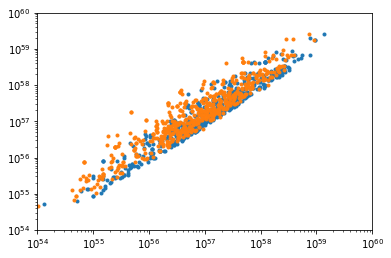

In [48]:
plt.scatter(min_lum, lum, marker='.')
plt.scatter(min_lum_new, lum_new, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.xlim([1e54, 1e60])
plt.ylim([1e54, 1e60])

# Differences Thus Far
- DM function different: more sophisticated DM model, but I don't subtract 30 and 50 for ISM and HALO contributions
- get z from DM function different: mine is more sophisticated due to Arcus/Zhang DM model
- L and MIN_L have different units

In [22]:
# def truncate_and_evolve(x, y, rs, evo=None):
#     if evo is None:
#         evo = np.ones(len(x))
#     return x[y > x], y[y > x]/evo[y > x], evo[y > x], rs[y > x]

# min_lum_trunc, lum_trunc, evo_trunc, rs_trunc = truncate_and_evolve(MIN_L, L, rs)

def truncate(x, y, evo=np.ones(len(fluence))):

    x_trunc = []
    y_trunc = []
    evo_trunc = []
    rs_trunc = []

    for i in range(len(x)):
        if (y[i] / evo[i]) > ((x[i] / evo[i])):
            x_trunc.append(x[i])
            y_trunc.append(y[i] / evo[i])
            evo_trunc.append(evo[i])
            rs_trunc.append(rs[i])
            
    return x_trunc, y_trunc, evo_trunc, rs_trunc

min_lum_trunc, lum_trunc, evo_trunc, rs_trunc = np.array(truncate(min_lum, lum))

In [23]:
#### assign ranks to redshifts in increasing order ####

def get_x_ranks(x, y, evo=np.ones(len(lum_trunc))):
    
    x_inc = np.argsort(x)
    
    x_ranks = []
    x_assoc_sets = []
    
    # iterate through redshift array, find associated set for each: all lum > lum(event i) with rs < rs(event i)
    for i in range(len(x)):
        curr = x_inc[i] # current event being analyzed
        y_assoc = []

        # iterate through luminosities, enforcing associated set constraints
        for j in range(len(y)):
            if y[j] > (x[curr] / evo[curr]) and x[j] < x[curr]:
                y_assoc.append(y[j])
                
        x_assoc_sets.append(len(y_assoc)) # number of events in current associated set
        y_assoc.append(y[curr])
    
        args = np.argwhere(np.sort(y_assoc) == y[curr])
        if len(args) > 1:
            x_ranks.append(np.average(args) + 1)  
        else:
            x_ranks.append(args[0,0] + 1)
            
    return x_ranks, x_assoc_sets

#### construct arrays for ranks of each redshift, and associated set of each redshift ####

x_ranks, x_assoc_sets = np.asarray(get_x_ranks(min_lum_trunc, lum_trunc))

In [24]:
#### construct normalized rank statistic vector 'T' ####

def get_T(ranks, sets):
    
    t = []
    
    for i in range(len(ranks)):
        n = sets[i] + 1
        if n > 1:
            mu = .5 * (1 + n)      # uniform RV expectation val
            var = (n**2 - 1) / 12  # uniform RV variance
            t.append((ranks[i] - mu) / float(math.sqrt(var)))
    return t

T = get_T(x_ranks, x_assoc_sets)
p = math.sqrt(len(T)) 
t_bar = np.sum(np.asarray(T) / (p**2))

#### construct kendall test statistic t_k using normal approx. ####

def t_kendall(vec, w=np.ones(len(T) + 1)):
    
    t_k = 0

    for i, t in enumerate(vec):
        t_k += w[i]*t
    
    return t_k / float(math.sqrt(np.sum(w**2)))

In [25]:
#### function which enables luminosity evolution as function of redshift and critical redshift ####

x_cr = 3.5

def get_evos(x, g):
    
    evo_low = x **g
    evo_hi = x **g * (1 + x_cr**g) / (x**g + x_cr**g)  #ansatz for luminosity evolution beyond critical redshift
    
    evos = []
    
    for i, val in enumerate(x):
        if val <= x_cr:
            evos.append(evo_low[i])
        else:
            evos.append(evo_hi[i])
            
    return np.asarray(evos)

#### function which computes the kendall statistic of a luminosity-evolution correction to CHIME cat1 ####

def kendall_evo(g):
    
    Z = 1 + rs
    evos = get_evos(Z, g)
    
    x_evos, y_evos, evos_trunc, rs_trunc = truncate(min_lum, lum, evo=evos)
    x_ranks, x_assoc_sets = np.array(get_x_ranks(x_evos, y_evos, evos_trunc))
    T = get_T(x_ranks, x_assoc_sets)
    
    return t_kendall(T), rs_trunc

In [26]:
g_space = np.linspace(2, 4.5, 20)
y = []
y_new = []

for i, val in enumerate(g_space):
    y.append(kendall_evo(val)[0])

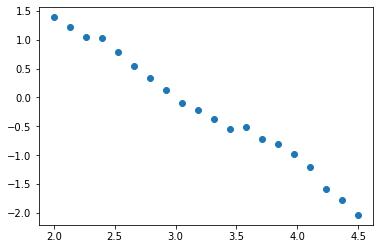

In [27]:
plt.scatter(g_space, y)